Install dependencies

In [65]:
!pip install -q sentence_transformers
!pip install -q chromadb
!pip install -q plotly
!pip install -q twilio
!pip install -q feedparser

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\jonas\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python313\\site-packages\\twilio\\rest\\api\\v2010\\account\\sip\\domain\\auth_types\\auth_type_registrations\\auth_registrations_credential_list_mapping.py'



Import libraries

In [3]:
import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import numpy as np
import pickle
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from items import Item
from sklearn.manifold import TSNE
import plotly.graph_objects as go
from testing import Tester
from openai import OpenAI
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib

Environment

In [4]:
load_dotenv()
hf_key = os.getenv("HUGGINGFACE_API_KEY")
gpt_key = os.getenv("OPENAI_API_KEY")
DB = "products_vectorstore"

login(token=hf_key, add_to_git_credential=True)

Load the train data

In [5]:
with open('train.pkl', 'rb') as f:
    train = pickle.load(f)

In [6]:
train[0].prompt

'How much does this cost to the nearest dollar?\n\nDelphi FG0166 Fuel Pump Module\nDelphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7\n\nPrice is $227.00'

Creating a chroma datastore

In [7]:
client = chromadb.PersistentClient(DB)

In [8]:
collection_name="products"

# Delete collection if already exists
existing_collections = client.list_collections()
if collection_name in existing_collections:
    client.delete_collection(collection_name)
    print(f"Deleted existing collection {collection_name}")

# Create a new collection
collection = client.create_collection(collection_name)

Sentence Transformers Model

In [9]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

Get the description

In [10]:
def description(item):
    text = item.prompt.replace("How much does this cost to the nearest dollar?\n\n", "")
    return text.split("\n\nPrice is $")[0]

In [11]:
description(train[0])

'Delphi FG0166 Fuel Pump Module\nDelphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7'

In [12]:
for i in tqdm(range(0,len(train), 1000)):
    documents = [description(item) for item in train[i:i+1000]]
    vectors = model.encode(documents).astype(float).tolist()
    metadatas = [{'category': item.category, 'price': item.price} for item in train[i:i+1000]]
    ids = [f"doc_{j}" for j in range(i, i+1000)]
    collection.add(
        ids=ids,
        documents=documents,
        embeddings=vectors,
        metadatas=metadatas,
    )

100%|██████████| 400/400 [27:35<00:00,  4.14s/it]


Visualizing 30'000 data points out of 400'000

In [13]:
MAXIMUM_DATAPOINTS = 30_000

In [14]:
collection = client.get_or_create_collection('products')

In [15]:
CATEGORIES = ['Appliances', 'Automotive', 'Cell_Phones_and_Accessories', 'Electronics','Musical_Instruments', 'Office_Products', 'Tools_and_Home_Improvement', 'Toys_and_Games']
COLORS = ['red', 'blue', 'brown', 'orange', 'yellow', 'green' , 'purple', 'cyan']

Data preparation

In [16]:
result = collection.get(include=['embeddings', 'documents', 'metadatas'], limit=MAXIMUM_DATAPOINTS)
vectors = np.array(result['embeddings'])
documents = result['documents']
categories = [metadata['category'] for metadata in result['metadatas']]
colors = [COLORS[CATEGORIES.index(c)] for c in categories]

In [17]:
tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
reduced_vectors = tsne.fit_transform(vectors)

2D Scatterplot

In [18]:
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=3, color=colors, opacity=0.7),
)])

fig.update_layout(
    title='2D Chroma Vectorstore Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y'),
    width=1200,
    height=800,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

Using Open AI

In [19]:
openai = OpenAI()


In [20]:
with open('test.pkl', 'rb') as f:
    test = pickle.load(f)

In [21]:
def make_context(similars, prices):
    message = "To provide some context, here are some other items that might be similar to the item you need to estimate.\n\n"
    for similar, price in zip(similars, prices):
        message += f"Potentially related product:\n{similar}\nPrice is ${price:.2f}\n\n"
    return message

In [22]:
def messages_for(item, similars, prices):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = make_context(similars, prices)
    user_prompt += "And now the question for you:\n\n"
    user_prompt += item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [23]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [24]:
def description(item):
    text = item.prompt.replace("How much does this cost to the nearest dollar?\n\n", "")
    return text.split("\n\nPrice is $")[0]

In [25]:
description(test[0])

"OEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K"

In [26]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [27]:
def vector(item):
    return model.encode([description(item)])

In [28]:
def find_similars(item):
    results = collection.query(query_embeddings=vector(item).astype(float).tolist(), n_results=5)
    documents = results['documents'][0][:]
    prices = [m['price'] for m in results['metadatas'][0][:]]
    return documents, prices

In [29]:
documents, prices = find_similars(test[1])

In [30]:
print(make_context(documents, prices))

To provide some context, here are some other items that might be similar to the item you need to estimate.

Potentially related product:
Motorcraft Fan Clutch Assembly - YB3130
Motorcraft Fan Clutch Assembly - YB3130 Package Dimensions 7.23 L x 4 H x 6.92 W (inches) Package Weight 5 pounds Country of Origin China Part Number YB3130 Manufacturer Motorcraft, Brand Motorcraft, Model Fan Clutch Assembly, Weight 5 pounds, Dimensions 6.87 x 7.32 x 5.62 inches, Country of Origin China, model number Exterior Painted, Manufacturer Part Wattage 6.92 watts, Rank Automotive Automotive Replacement Engine Fan Clutches 698, Available October 10, 2007, Dimensions LxWxH 6.87 x 7.32 x 5.62 inches
Price is $223.78

Potentially related product:
Motorcraft- YB3126 Fan Clutch
Fan Clutch Package Dimensions 16.764 H x 24.384 L x 20.32 W (centimeters) Part number YB3126 Package Weight 7.4 pounds Fit type Vehicle Specific Brand Motorcraft, Electric fan design Blower, Power Source Electric, Style Modern, Dimensi

In [31]:
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [32]:
def gpt_4o_mini_rag(item):
    documents, prices = find_similars(item)
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item, documents, prices),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [33]:
gpt_4o_mini_rag(test[1])

201.45

In [34]:
test[1].price

225.11

In [35]:
with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

1: Guess: $312.41 Truth: $374.41 Error: $62.00 SLE: 0.03 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $201.45 Truth: $225.11 Error: $23.66 SLE: 0.01 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $44.99 Truth: $61.68 Error: $16.69 SLE: 0.10 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $399.99 Truth: $599.99 Error: $200.00 SLE: 0.16 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $19.99 Truth: $16.99 Error: $3.00 SLE: 0.02 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $12.99 Truth: $31.99 Error: $19.00 SLE: 0.74 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $68.99 Truth: $101.79 Error: $32.80 SLE: 0.15 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $399.00 Truth: $289.00 Error: $110.00 SLE: 0.10 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $699.99 Truth: $635.86 Error: $64.13 SLE: 0.01 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $56.99 Truth: $65.99 Error: $9.00 SLE: 0.02 Ite

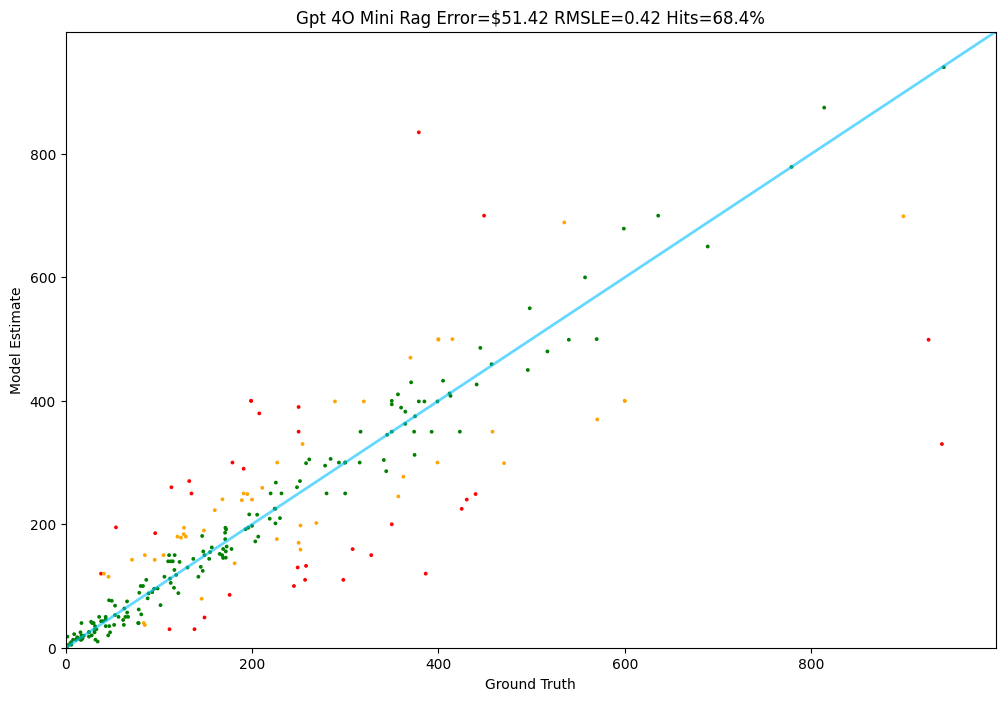

In [36]:
Tester.test(gpt_4o_mini_rag, test) 

Complex Solution

In [37]:
#Constants
QUESTION = "How much does this cost to the nearest dollar?\n\n"
DB = "products_vectorstore"

In [38]:
load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HUGGINGFACE_API_KEY'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [39]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [41]:
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
prices = [metadata['price'] for metadata in result['metadatas']]

Random Forest Model

In [42]:
rf_model = RandomForestRegressor(n_estimators=60, random_state=42, n_jobs=-1)
rf_model.fit(vectors, prices)

RandomForestRegressor(n_estimators=60, n_jobs=-1, random_state=42)

In [43]:
if not os.path.exists('random_forest_model.pkl'):
    joblib.dump(rf_model, 'random_forest_model.pkl')

In [44]:
rf_model = joblib.load('random_forest_model.pkl')

In [45]:
from agents.specialist_agent import SpecialistAgent
from agents.frontier_agent import FrontierAgent
from agents.random_forest_agent import RandomForestAgent

In [46]:
specialist = SpecialistAgent()
frontier = FrontierAgent(collection)
random_forest = RandomForestAgent()

Get the description

In [47]:
def description(item):
    return item.prompt.split("to the nearest dollar?\n\n")[1].split("\n\nPrice is $")[0]

In [48]:
def rf(item):
    return random_forest.price(description(item))

1: Guess: $303.52 Truth: $374.41 Error: $70.89 SLE: 0.04 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $195.44 Truth: $225.11 Error: $29.67 SLE: 0.02 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $218.51 Truth: $61.68 Error: $156.83 SLE: 1.57 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $401.54 Truth: $599.99 Error: $198.45 SLE: 0.16 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $210.28 Truth: $16.99 Error: $193.29 SLE: 6.07 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $56.33 Truth: $31.99 Error: $24.34 SLE: 0.31 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $252.22 Truth: $101.79 Error: $150.43 SLE: 0.81 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $215.80 Truth: $289.00 Error: $73.20 SLE: 0.08 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $281.64 Truth: $635.86 Error: $354.22 SLE: 0.66 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $200.32 Truth: $65.99 Error: $134.33 SLE

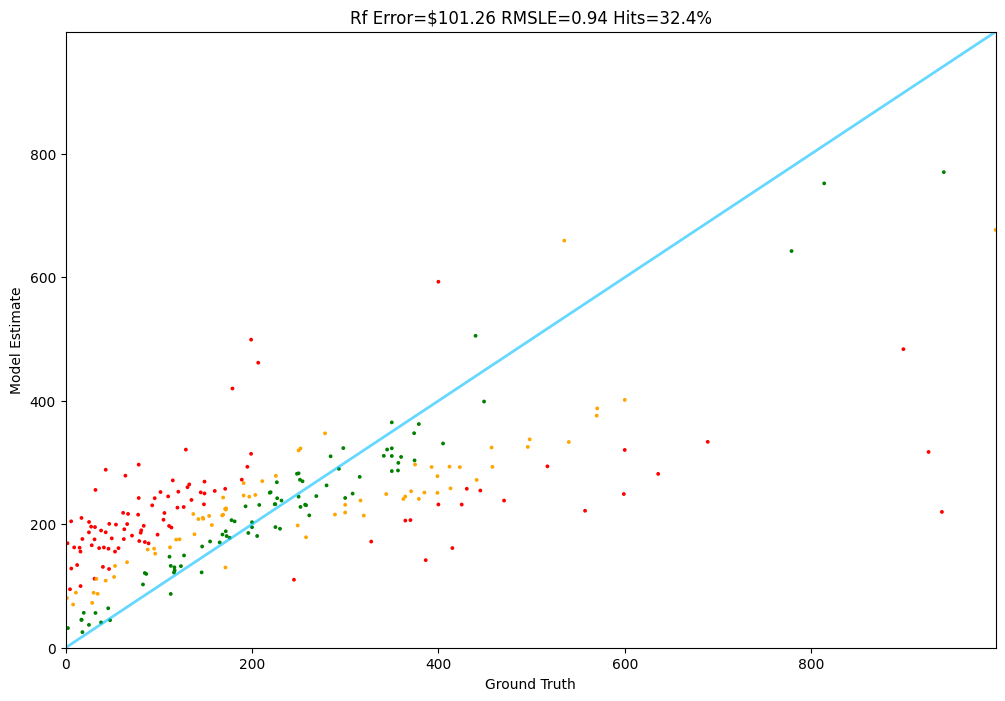

In [49]:
Tester.test(rf, test)

In [50]:
product = "Quadcast HyperX condenser mic for high quality audio for podcasting"

In [51]:
print(specialist.price(product))
print(frontier.price(product))
print(random_forest.price(product))

189.0
195.19
301.4583333333334


In [52]:
specialists = []
frontiers = []
random_forests = []
prices = []
for item in tqdm(test[1000:1250]):
    text = description(item)
    specialists.append(specialist.price(text))
    frontiers.append(frontier.price(text))
    random_forests.append(random_forest.price(text))
    prices.append(item.price)

100%|██████████| 250/250 [19:42<00:00,  4.73s/it]  


In [53]:
mins = [min(s,f,r) for s,f,r in zip(specialists, frontiers, random_forests)]
maxes = [max(s,f,r) for s,f,r in zip(specialists, frontiers, random_forests)]

X = pd.DataFrame({
    'Specialist': specialists,
    'Frontier': frontiers,
    'RandomForest': random_forests,
    'Min': mins,
    'Max': maxes,
})

# Convert y to a Series
y = pd.Series(prices)

Train Linear Regression

In [54]:
np.random.seed(42)

lr = LinearRegression()
lr.fit(X, y)
feature_columns = X.columns.to_list()

for features, coef in zip(feature_columns, lr.coef_):
    print(f"{features}: {coef}")
print(f"Intercept={lr.intercept_:.2f}")

Specialist: 0.465138847373631
Frontier: 0.2653038202755524
RandomForest: -0.32917572080533014
Min: 0.2948976307912783
Max: 0.2543552544017127
Intercept=29.69


In [57]:
if not os.path.exists('ensemble_model.pkl'):
    joblib.dump(lr, 'ensemble_model.pkl')

In [58]:
from agents.ensemble_agent import EnsembleAgent
ensemble = EnsembleAgent(collection)

In [59]:
ensemble.price(product)

np.float64(202.5646774595592)

In [60]:
def essemble_pricer(item):
    return ensemble.price(description(item))

1: Guess: $398.60 Truth: $374.41 Error: $24.19 SLE: 0.00 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $208.37 Truth: $225.11 Error: $16.74 SLE: 0.01 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $48.84 Truth: $61.68 Error: $12.84 SLE: 0.05 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $371.78 Truth: $599.99 Error: $228.21 SLE: 0.23 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $33.70 Truth: $16.99 Error: $16.71 SLE: 0.43 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $41.59 Truth: $31.99 Error: $9.60 SLE: 0.07 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $111.33 Truth: $101.79 Error: $9.54 SLE: 0.01 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $368.71 Truth: $289.00 Error: $79.71 SLE: 0.06 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $889.26 Truth: $635.86 Error: $253.40 SLE: 0.11 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $70.86 Truth: $65.99 Error: $4.87 SLE: 0.00 Ite

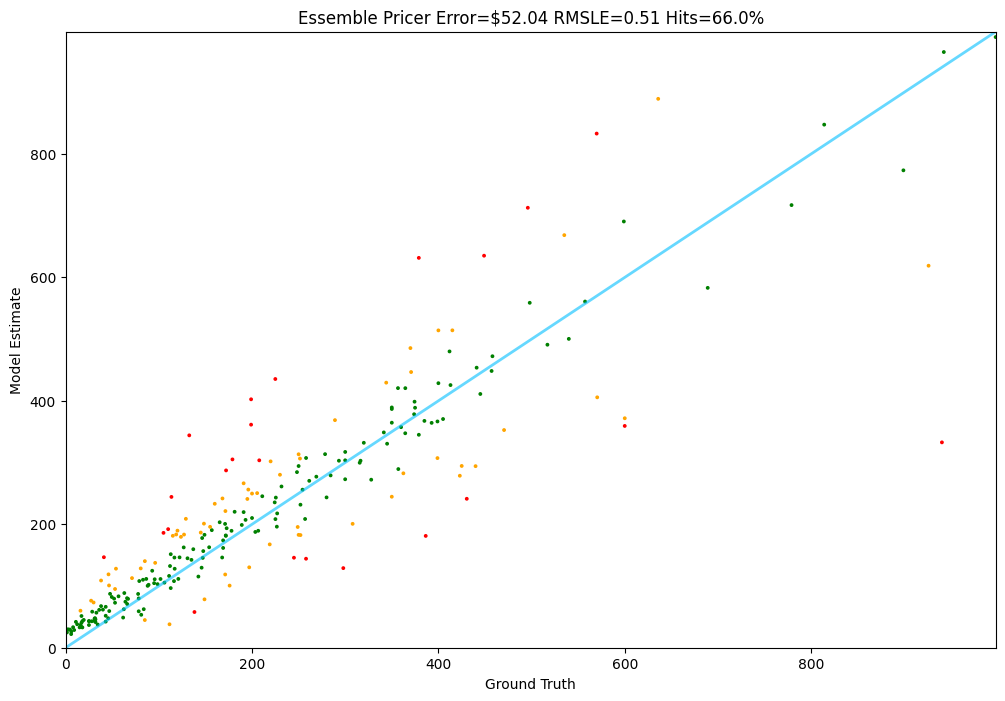

In [61]:
Tester.test(essemble_pricer, test)

Add a Gradio Interface

In [66]:
import gradio as gr
from deal_agent_framework import DealAgentFramework
from agents.deals import Opportunity, Deal

In [67]:
with gr.Blocks(title="The Price is Right", fill_width=True) as ui:

    with gr.Row():
        gr.Markdown('<div style="text-align: center;font-size:24px">The Price is Right - Deal Hunting Agentic AI</div>')
    with gr.Row():
        gr.Markdown('<div style="text-align: center;font-size:14px">Autonomous agent framework that finds online deals, collaborating with a proprietary fine-tuned LLM deployed on Modal, and a RAG pipeline with a frontier model and Chroma.</div>')
        

ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [68]:
with gr.Blocks(title="The Price is Right", fill_width=True) as ui:

    initial_deal = Deal(product_description="Example description", price=100.0, url="https://cnn.com")
    initial_opportunity = Opportunity(deal=initial_deal, estimate=200.0, discount=100.0)
    opportunities = gr.State([initial_opportunity])

    def get_table(opps):
        return [[opp.deal.product_description, opp.deal.price, opp.estimate, opp.discount, opp.deal.url] for opp in opps]

    with gr.Row():
        gr.Markdown('<div style="text-align: center;font-size:24px">"The Price is Right" - Deal Hunting Agentic AI</div>')
    with gr.Row():
        gr.Markdown('<div style="text-align: center;font-size:14px">Deals surfaced so far:</div>')
    with gr.Row():
        opportunities_dataframe = gr.Dataframe(
            headers=["Description", "Price", "Estimate", "Discount", "URL"],
            wrap=True,
            column_widths=[4, 1, 1, 1, 2],
            row_count=10,
            col_count=5,
            max_height=400,
        )

    ui.load(get_table, inputs=[opportunities], outputs=[opportunities_dataframe])

ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


In [69]:
agent_framework = DealAgentFramework()

with gr.Blocks(title="The Price is Right", fill_width=True) as ui:

    initial_deal = Deal(product_description="Example description", price=100.0, url="https://cnn.com")
    initial_opportunity = Opportunity(deal=initial_deal, estimate=200.0, discount=100.0)
    opportunities = gr.State([initial_opportunity])

    def get_table(opps):
        return [[opp.deal.product_description, opp.deal.price, opp.estimate, opp.discount, opp.deal.url] for opp in opps]

    def do_select(opportunities, selected_index: gr.SelectData):
        row = selected_index.index[0]
        opportunity = opportunities[row]
        agent_framework.planner.messenger.alert(opportunity)

    with gr.Row():
        gr.Markdown('<div style="text-align: center;font-size:24px">"The Price is Right" - Deal Hunting Agentic AI</div>')
    with gr.Row():
        gr.Markdown('<div style="text-align: center;font-size:14px">Deals surfaced so far:</div>')
    with gr.Row():
        opportunities_dataframe = gr.Dataframe(
            headers=["Description", "Price", "Estimate", "Discount", "URL"],
            wrap=True,
            column_widths=[4, 1, 1, 1, 2],
            row_count=10,
            col_count=5,
            max_height=400,
        )

    ui.load(get_table, inputs=[opportunities], outputs=[opportunities_dataframe])
    opportunities_dataframe.select(do_select, inputs=[opportunities], outputs=[])

ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7862


INFO:httpx:HTTP Request: GET http://127.0.0.1:7862/gradio_api/startup-events "HTTP/1.1 200 OK"


[2025-02-11 12:04:48 -0800] [Agents] [INFO] HTTP Request: GET http://127.0.0.1:7862/gradio_api/startup-events "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: HEAD http://127.0.0.1:7862/ "HTTP/1.1 200 OK"


[2025-02-11 12:04:48 -0800] [Agents] [INFO] HTTP Request: HEAD http://127.0.0.1:7862/ "HTTP/1.1 200 OK"

To create a public link, set `share=True` in `launch()`.


INFO:httpx:HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"


[2025-02-11 12:04:49 -0800] [Agents] [INFO] HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"


Traceback (most recent call last):
  File "C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\gradio\queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
    )
    ^
  File "C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\gradio\route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<11 lines>...
    )
    ^
  File "C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\gradio\blocks.py", line 2042, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<8 lines>...
    )
    ^
 